In [13]:
import numpy as np
import pandas as pd
import matplotlib as plt
import torch 
import torch.nn as nn
import yfinance as yf
import keras 
import os
import tensorflow
import datetime 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras import optimizers
from keras.models import Model
from keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [47]:
def TickerIntoTensor(ticker='aapl',daysago=100,daysforward=1,split_percentage=0.9):
    df = yf.Ticker(ticker.upper())
    df = df.history(period='max')
    if df.shape[1] == 7:
        df = df.drop(columns=['Dividends','Stock Splits'])
    df = df.drop(columns=['Open','High','Low','Volume'])
    for i in range(daysago,-daysforward-1,-1):
        df['{}daysago'.format(i)] = df['Close'].shift(i)
        df = df.copy()
    df = df.drop(columns=['Close'])
    df = df.drop(index=df.tail(daysforward).index)
    df = df.drop(index=df.head(daysago).index)
    sc = MinMaxScaler(feature_range=(0,1))
    df_scaled = sc.fit_transform(df)
    X,Y = df_scaled[:,:daysago+1],df_scaled[:,-daysforward:]
    if split_percentage == -1:
        split = split_percentage
    else:
        split = int(len(X)*split_percentage)
    X_train, X_test, Y_train, Y_test = X[:split], X[split:], Y[:split], Y[split:]
    X_train, X_test = X_train.reshape((-1,daysago+1,1)), X_test.reshape((-1,daysago+1,1))
    if daysforward == 1:
        Y_train, Y_test = Y_train.reshape((-1,1)), Y_test.reshape((-1,1))
    else:
        Y_train, Y_test = Y_train.reshape((-1,daysforward)), Y_test.reshape((-1,daysforward))
    return X_train, X_test, Y_train, Y_test
TickerIntoTensor()

(array([[[3.09576755e-04],
         [2.83417192e-04],
         [2.48533449e-04],
         ...,
         [2.72269652e-04],
         [2.56185037e-04],
         [2.60537176e-04]],
 
        [[2.83417192e-04],
         [2.48533449e-04],
         [2.59433421e-04],
         ...,
         [2.60346191e-04],
         [2.62051430e-04],
         [2.64425528e-04]],
 
        [[2.48533449e-04],
         [2.59433421e-04],
         [2.72517257e-04],
         ...,
         [2.66307870e-04],
         [2.65962380e-04],
         [2.54704682e-04]],
 
        ...,
 
        [[2.78138553e-01],
         [2.81889999e-01],
         [2.89392947e-01],
         ...,
         [3.35563837e-01],
         [3.19707977e-01],
         [3.32612279e-01]],
 
        [[2.81889999e-01],
         [2.89392947e-01],
         [2.88976105e-01],
         ...,
         [3.24900919e-01],
         [3.34545436e-01],
         [3.21817878e-01]],
 
        [[2.89392947e-01],
         [2.88976105e-01],
         [2.88301843e-01],
         

In [71]:

import DataPrep as ddd
daysago = 100
daysforward = 1
e = ddd.TickerIntoTensor('^gspc', daysago, daysforward)
X_train, X_test, Y_train, Y_test = e[0], e[1], e[2], e[3]


model1 = Sequential()
model1.add(InputLayer((daysago+1, 1)))
model1.add(LSTM(daysago*daysforward))
model1.add(Dense(daysago, 'sigmoid'))
model1.add(Dense(daysforward, 'linear'))

cp1 = ModelCheckpoint('model/.keras', save_best_only=False)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])
model1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=128, callbacks=[cp1])

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - loss: 0.0169 - root_mean_squared_error: 0.1172 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0626
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 4.3689e-06 - root_mean_squared_error: 0.0021 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 3.0156e-06 - root_mean_squared_error: 0.0017 - val_loss: 4.2281e-04 - val_root_mean_squared_error: 0.0206
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 3.2690e-06 - root_mean_squared_error: 0.0018 - val_loss: 2.3445e-04 - val_root_mean_squared_error: 0.0153
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - loss: 3.5874e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.4655e-04 - val_root_mean_squared_error: 0.0121
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - loss: 4.9101e-06 - root_mean_squared_error: 0.0022 - val_loss: 6.2685e-04 - val_root_mean_squared_error: 0.0250
Epoc

In [74]:
from tensorflow.keras.models import load_model
model1 = load_model('model/.keras')
y_pred = model1.predict(ddd.TickerIntoTensor('goog',daysago,daysforward,0.8)[1])
Y_test = ddd.TickerIntoTensor('goog',daysago,daysforward,0.8)[3].reshape(-1,daysforward)
avg_error = (np.sum(np.sqrt((Y_test - y_pred)**2)))/len(Y_test)*100

print(avg_error)
avg_error = (np.sum(y_pred - Y_test))/len(Y_test)*100
print(avg_error)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1.2591293191556752
0.6005990328330949


In [63]:
1.396277199229622
0.0712268690431024

0.0712268690431024

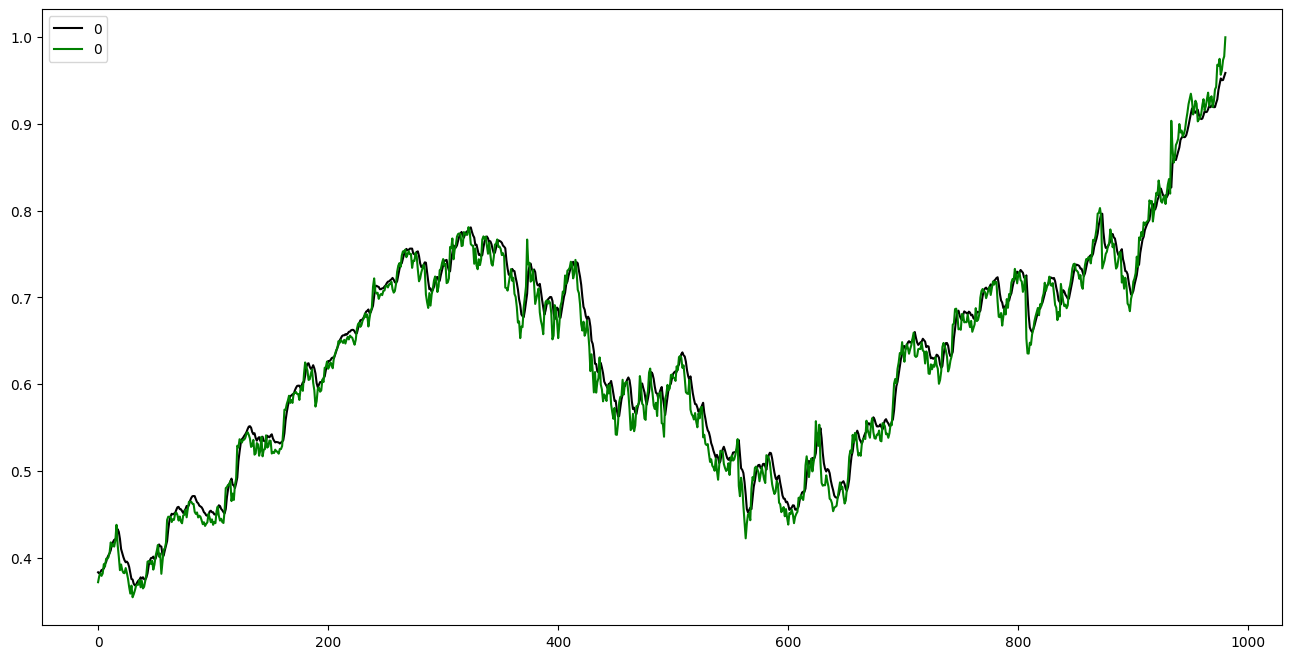

In [75]:
y_pred,Y_test = pd.DataFrame(y_pred),pd.DataFrame(Y_test)
for i in range(0,y_pred.shape[1]): 
    oneday= pd.concat([y_pred[i],Y_test[i]],axis=1)
    oneday.plot(figsize=(16,8),color = ('black','green'))
    

<Axes: >

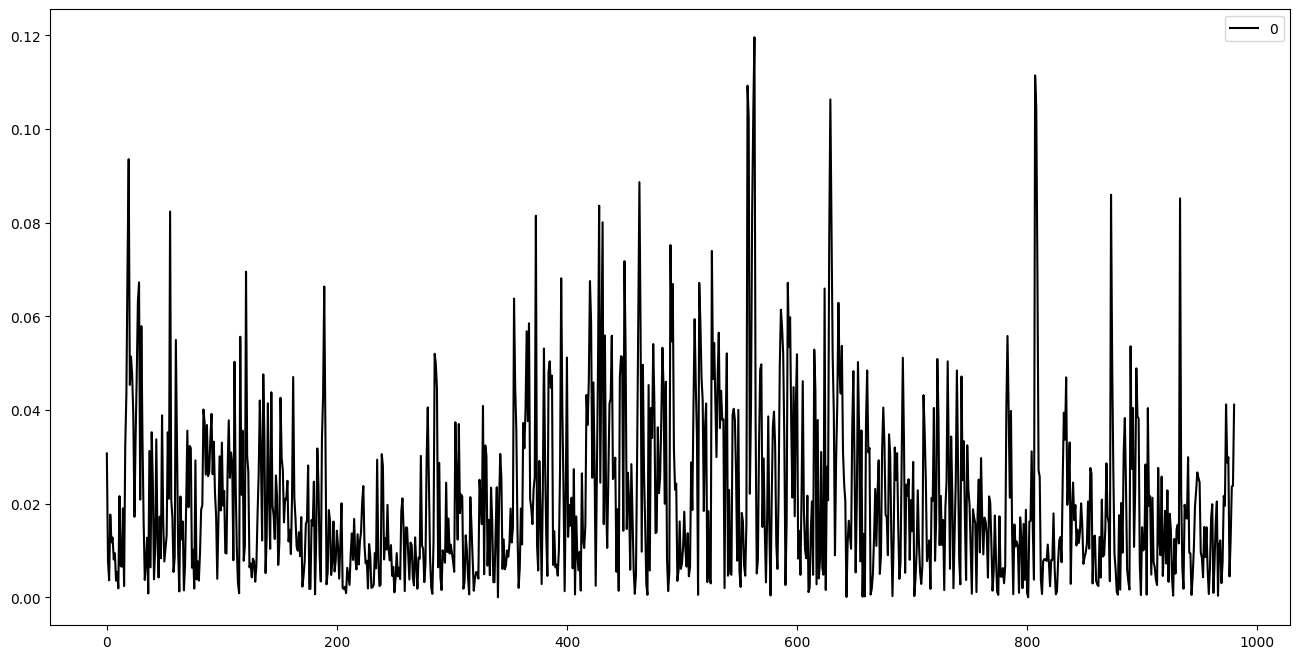

In [80]:
(np.abs(y_pred - Y_test)/Y_test).plot(figsize=(16,8),color = ('black','green'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

<Axes: >

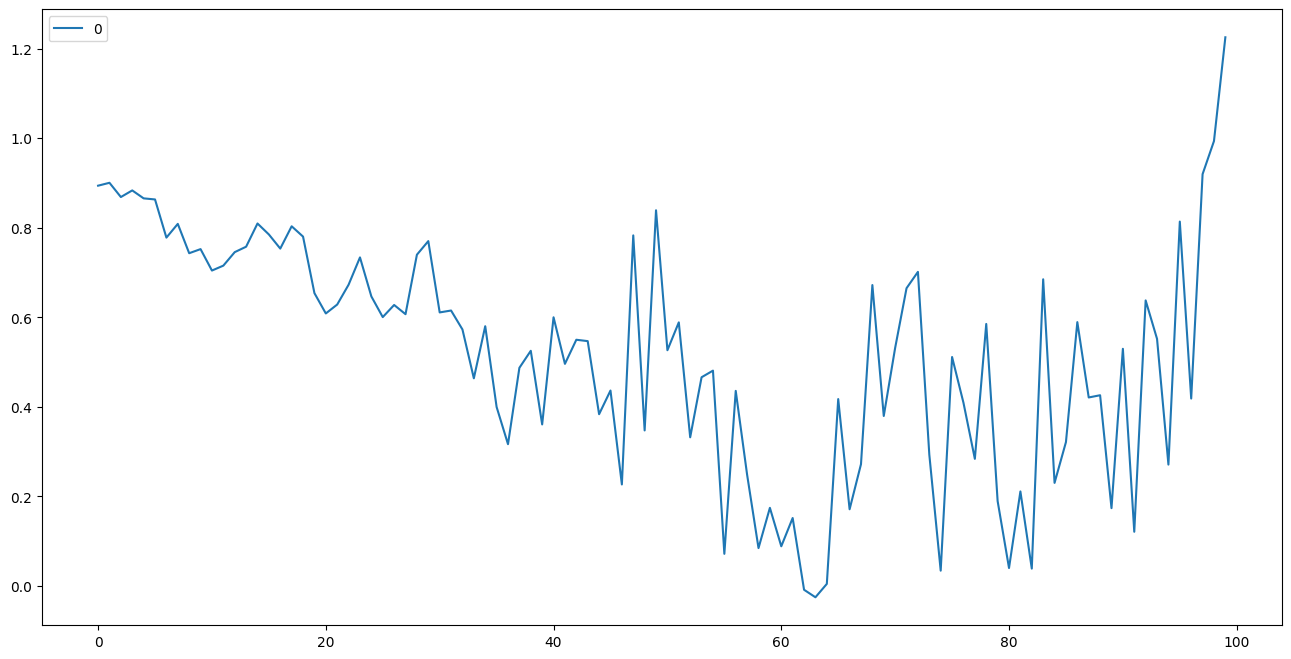

In [32]:
import random
def UserInput_Two(ticker='aapl',daysago=100,futureproj=20):
    X_test = TickerIntoTensor(ticker,daysago,1,-1)[1]
    y_pred_proj = []
    for i in range(1,futureproj+1):
        y_pred = model1.predict(X_test)
        #y_pred = y_pred * random.uniform((np.min(X_test)-y_pred)/np.min(X_test),(np.max(X_test)-y_pred)/np.max(X_test))
        y_pred = y_pred + (np.std(X_test) * random.normalvariate(0,1))
        y_pred_proj = np.append(y_pred_proj,y_pred)
        X_test = X_test.reshape((-1))
        X_test = np.append(X_test, y_pred)
        #X_test = X_test[1:]
        X_test = X_test.reshape((-1,daysago+1+i,1))
    return y_pred_proj 


e = pd.DataFrame(UserInput_Two('nvda',100,100))
e.plot(figsize=(16,8))